## Intro variables

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
from copy import deepcopy

PALETTE_PARAMS='Accent'

PALETTE='Set2'

ST3="data/test10000_best_hallmark__compare_results.tsv"
VALIDATION_COMPARISON = 'data/aggregated_sim_best.csv'

def line_break(s, split=', ', k=3):
    items = s.split(split)
    grouped_items = [split.join(items[i:i+k]) for i in range(0, len(items), k)]
    return ',\n'.join(grouped_items)

In [2]:
ct_name = "Total"  #'Знач. наб. SNP' # clumps total
cc_name = "Precision"  #'СС (Доля наборов, содержащих причинные SNP)'
cnc_name = "FDR"
sf_name = "Recall"  #'SF (Доля найденных причинных SNP)'
snf_name = "FNR"

column_names = {
    "m/sd": "m_beta / sd_beta",
    "m_beta": "effect size (m_beta)",
    "sd_beta": "standard deviation of effect size (sd_beta)",
    "gen_var": "genetic effects variance (gen_var)",
    "alpha": "variance of shared observational noise effect (alpha)",
    "theta": "proportion of variance\nof shared genetic variant effects (theta)",
    "pIndep": "proportion of genetic variant effects\nto have a trait-independent fixed effect (pIndependent)",
    "K": "amount of causal SNPs (K); k=K/2",
    "_":"",
    'gv/K':"gen.var./K"
}

## Read iteration 2 clumped dataset

In [3]:
data = pd.read_csv(ST3, sep='\t').rename(columns={'clumps_causal':cc_name, 'clumps_not_causal':cnc_name, "causal_found": sf_name, "causal_not_found": snf_name, 'clumps_total': ct_name})
data['F1'] = 2/(1/data.Precision+1/data.Recall)
data['m/sd']= np.round(data['m_beta']/data['sd_beta'], 3)
data['gv/K']= np.round(data['gen_var']/data['K'], 3)
print(data.shape)
data.head()

(400, 17)


,index,m_beta,sd_beta,gen_var,alpha,theta,pIndep,K,seed,Total,Precision,FDR,Recall,FNR,F1,m/sd,gv/K
0,6.0,0.05,0.001,0.1,0.0,0.0,1.0,10,8730575,10,1.00000,0.00000,1.0,0.0,1.00000,50.0,0.01
1,6.0,0.05,0.001,0.1,0.0,0.0,1.0,10,692974,10,1.00000,0.00000,1.0,0.0,1.00000,50.0,0.01
2,6.0,0.05,0.001,0.1,0.0,0.0,1.0,10,504779,10,1.00000,0.00000,1.0,0.0,1.00000,50.0,0.01
3,6.0,0.05,0.001,0.1,0.0,0.0,1.0,10,9809543,11,0.90909,0.09091,1.0,0.0,0.95238,50.0,0.01
4,6.0,0.05,0.001,0.1,0.0,0.0,1.0,10,1351011,10,0.90000,0.10000,0.9,0.1,0.90000,50.0,0.01


## Check group by params
(Average by all seeds and K)

In [4]:
grouped_data = data.groupby(["m_beta", "sd_beta", "gen_var", "alpha", "theta", "m/sd", "gv/K", "pIndep", "K"]).agg(
    {"Total":"mean", "Precision": "mean", "FDR": "mean", "Recall": "mean", "FNR": "mean", "F1": "mean"}
).reset_index()

grouped_data

,m_beta,sd_beta,gen_var,alpha,theta,m/sd,gv/K,pIndep,K,Total,Precision,FDR,Recall,FNR,F1
0,0.05,0.001,0.1,0.0,0.0,50.0,0.010,1.0,10,10.25,0.963030,0.036970,0.985000,0.015000,0.973312
1,0.05,0.001,0.1,0.0,0.5,50.0,0.010,0.5,10,10.35,0.963181,0.036819,0.995000,0.005000,0.978333
2,0.05,0.001,0.1,0.0,1.0,50.0,0.010,0.0,10,9.85,0.978030,0.021970,0.960000,0.040000,0.967259
3,0.05,0.001,0.1,0.5,0.0,50.0,0.003,1.0,30,15.30,0.933579,0.066421,0.474999,0.525001,0.627888
4,0.05,0.001,0.1,0.5,0.0,50.0,0.005,1.0,20,13.35,0.929578,0.070422,0.620000,0.380000,0.741123
5,0.05,0.001,0.1,0.5,0.0,50.0,0.010,1.0,10,10.10,0.976818,0.023182,0.985000,0.015000,0.980213
6,0.05,0.001,0.1,0.5,1.0,50.0,0.005,0.0,20,13.40,0.942077,0.057923,0.630000,0.370000,0.752420
7,0.05,0.001,0.5,0.5,1.0,50.0,0.017,0.0,30,43.15,0.692889,0.307111,0.990001,0.009999,0.813922
8,0.05,0.010,0.1,0.0,0.0,5.0,0.010,1.0,10,9.75,0.954393,0.045607,0.925000,0.075000,0.937710
9,0.05,0.010,0.1,0.0,1.0,5.0,0.010,0.0,10,9.75,0.969697,0.030304,0.940000,0.060000,0.951602


In [5]:
# List of K values to process
K_values = [10, 20, 30]

# Creating an empty DataFrame for the merged results
merged_df = pd.DataFrame()

f1_cols = []

# Looping through each K value
for K in K_values:
    # Filtering the DataFrame for the current K value
    df_filtered = grouped_data[grouped_data['K'] == K][['m_beta', 'sd_beta', 'gen_var', 'alpha', 'theta', "m/sd", 'pIndep', 'Total', 'Precision', 'FDR', 'Recall', 'FNR', 'F1']]
    
    # Renaming the columns to include the K value
    df_filtered.rename(columns=lambda x: x + f' (K={K})' if x not in ['m_beta', 'sd_beta', 'gen_var', 'alpha', 'theta', 'pIndep', "m/sd"] else x, inplace=True)
    
    # Merging with the main DataFrame
    if merged_df.empty:
        merged_df = df_filtered
    else:
        merged_df = pd.merge(merged_df, df_filtered, on=['m_beta', 'sd_beta', 'gen_var', 'alpha', 'theta', 'pIndep', "m/sd", ], how='outer')
    # save names of f1
    f1_cols.append(f'F1 (K={K})')
        

merged_df['F1_avg']=merged_df[f1_cols].mean(axis=1)
merged_df.to_csv(VALIDATION_COMPARISON, sep=',', index=False)
merged_df

,m_beta,sd_beta,gen_var,alpha,theta,m/sd,pIndep,Total (K=10),Precision (K=10),FDR (K=10),...,Recall (K=20),FNR (K=20),F1 (K=20),Total (K=30),Precision (K=30),FDR (K=30),Recall (K=30),FNR (K=30),F1 (K=30),F1_avg
0,0.05,0.001,0.1,0.0,0.0,50.0,1.0,10.25,0.963030,0.036970,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.973312
1,0.05,0.001,0.1,0.0,0.5,50.0,0.5,10.35,0.963181,0.036819,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.978333
2,0.05,0.001,0.1,0.0,1.0,50.0,0.0,9.85,0.978030,0.021970,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.967259
3,0.05,0.001,0.1,0.5,0.0,50.0,1.0,10.10,0.976818,0.023182,...,0.620,0.380,0.741123,15.30,0.933579,0.066421,0.474999,0.525001,0.627888,0.783075
4,0.05,0.010,0.1,0.0,0.0,5.0,1.0,9.75,0.954393,0.045607,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.937710
5,0.05,0.010,0.1,0.0,1.0,5.0,0.0,9.75,0.969697,0.030304,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.951602
6,0.50,0.010,0.1,0.0,0.0,50.0,1.0,9.90,0.980909,0.019091,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.974712
7,0.50,0.010,0.1,0.0,0.5,50.0,0.5,10.15,0.981818,0.018182,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.987845
8,0.50,0.010,0.1,0.0,1.0,50.0,0.0,10.10,0.971818,0.028182,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.975213
9,0.50,0.010,0.1,0.5,0.0,50.0,1.0,10.20,0.963939,0.036061,...,0.625,0.375,0.747467,15.45,0.947317,0.052683,0.488333,0.511666,0.642055,0.786725


## Precision-recall scatter plot

In [6]:
d = data

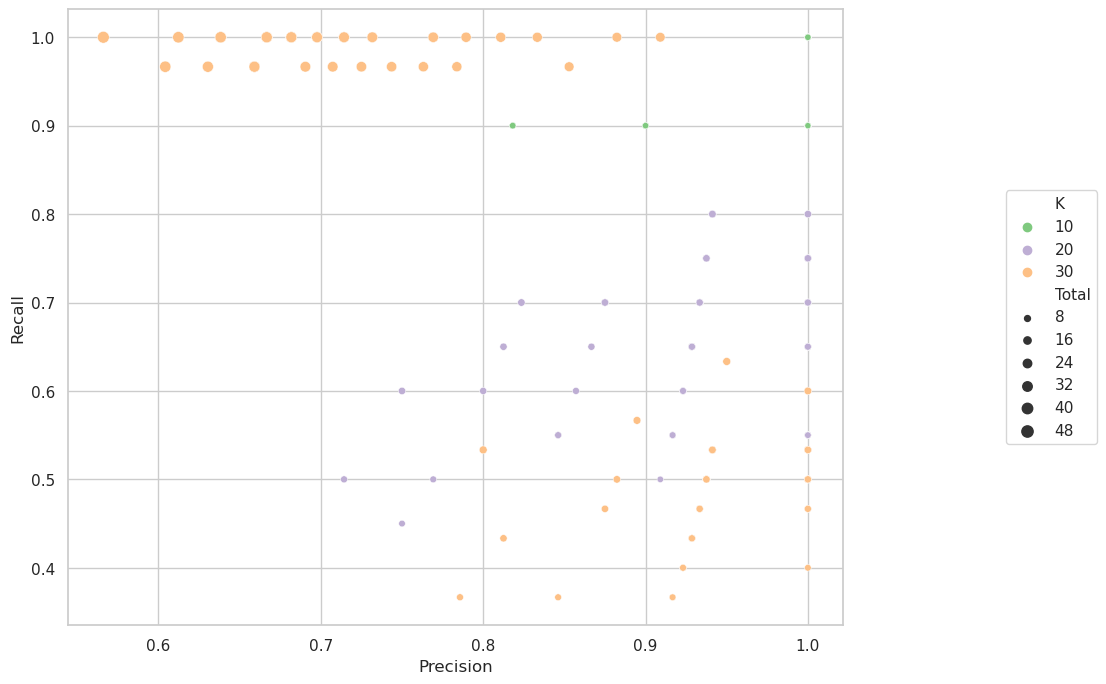

In [7]:
sns.set()
plt.figure(figsize=(10,8))
sns.set_theme(style="whitegrid")
ax = sns.scatterplot(d, 
                     x='Precision', 
                     y='Recall', 
                     hue='K', 
                     size=ct_name, 
                     palette=PALETTE_PARAMS,  
                     alpha=1,)

plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.5))
plt.savefig('images/SF4.2.pdf')
plt.show()

## Distributions of precision and recall relatively to params

In [8]:
def draw_violins(d, cur_y, cur_name, columns, name = '', min_y=-0.05, max_y=1.05):
    sns.set(rc={"figure.figsize": (15, 10)})
    sns.set_theme(style="whitegrid")
    # get legend
    ax = sns.violinplot(d, 
                        x=columns[0], 
                        y=cur_y, 
                        palette=PALETTE_PARAMS,
                        hue='K')
    handles, labels = ax.get_legend_handles_labels()
    plt.clf()
    # draw
    fig, axs = plt.subplots(nrows=2, ncols=2)
    for i, c in enumerate(columns):
        if c=='_':
            continue
        row = i // 2
        col = i % 2
        ax = sns.stripplot(d, 
                            x=c, 
                            y=cur_y, 
                            hue='K', 
                            palette=PALETTE_PARAMS,
                            alpha=.7,
                            ax=axs[row][col], 
                            legend=False, 
                           dodge=True
                           )
        
        ax = sns.violinplot(d, 
                            x=c, 
                            y=cur_y, 
                            hue='K', 
                            palette=PALETTE_PARAMS,
                            alpha=.7,
                            ax=axs[row][col], 
                            legend=False, 
                            cut=0
                           )
        plt.setp(ax.collections, alpha=.58)
        ax.legend_.remove()
        ax.set(ylabel='', xlabel=column_names[c])
        ax.set(ylim=(min_y, max_y))
        ax
    fig.supylabel(cur_name, y=0.5, x=0.07)
    fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.9, 0.5), title=column_names['K'])
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
    if name != '':
        plt.savefig(name)
    plt.show()

In [9]:
columnses = [["m_beta", "sd_beta", "m/sd", "gen_var"], 
            ["alpha","theta","pIndep",'gv/K',]]

<Figure size 1500x1000 with 0 Axes>

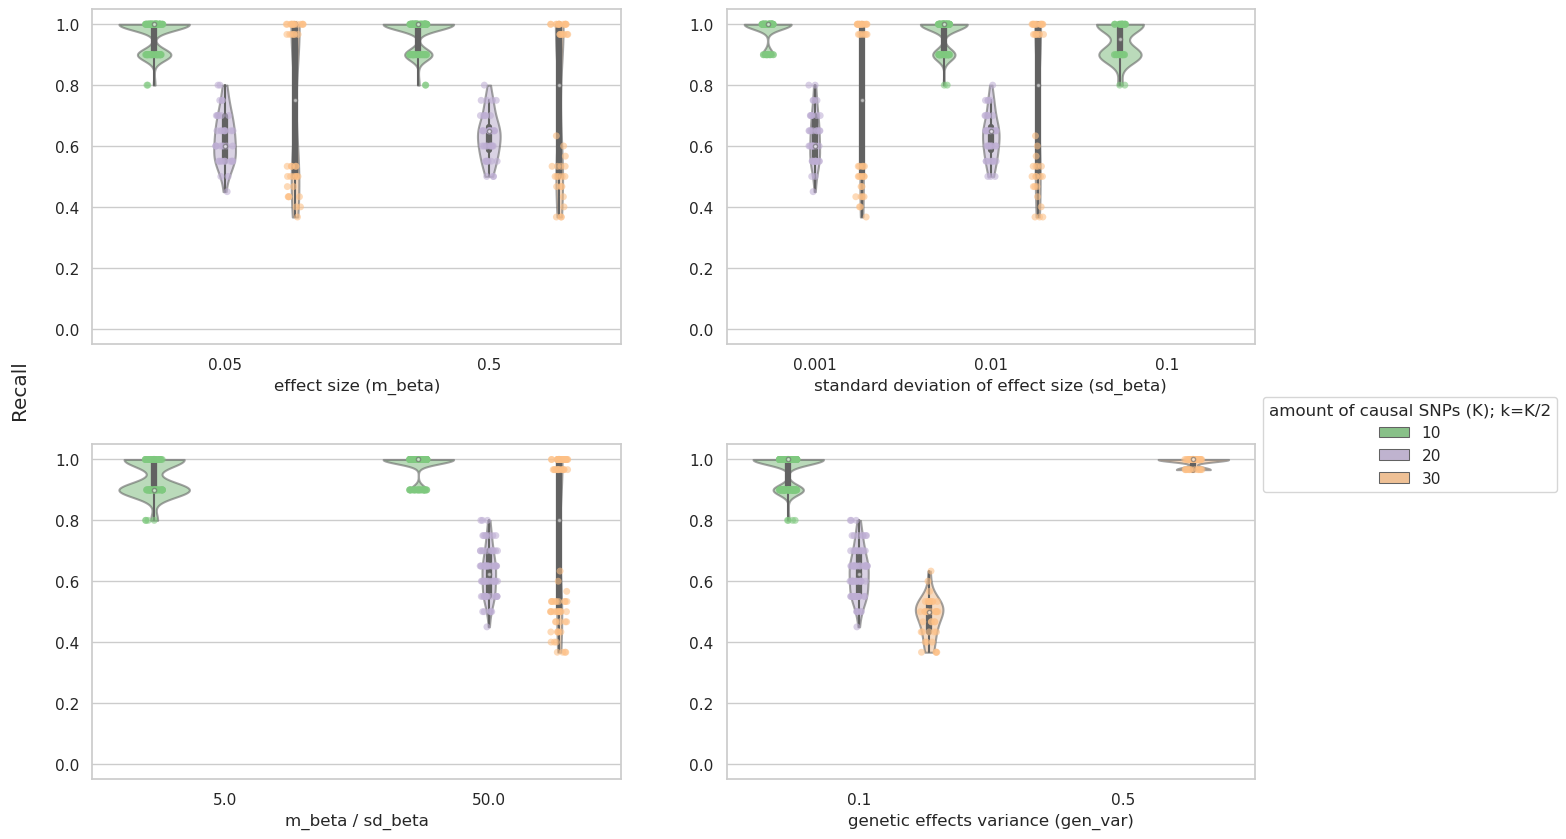

<Figure size 1500x1000 with 0 Axes>

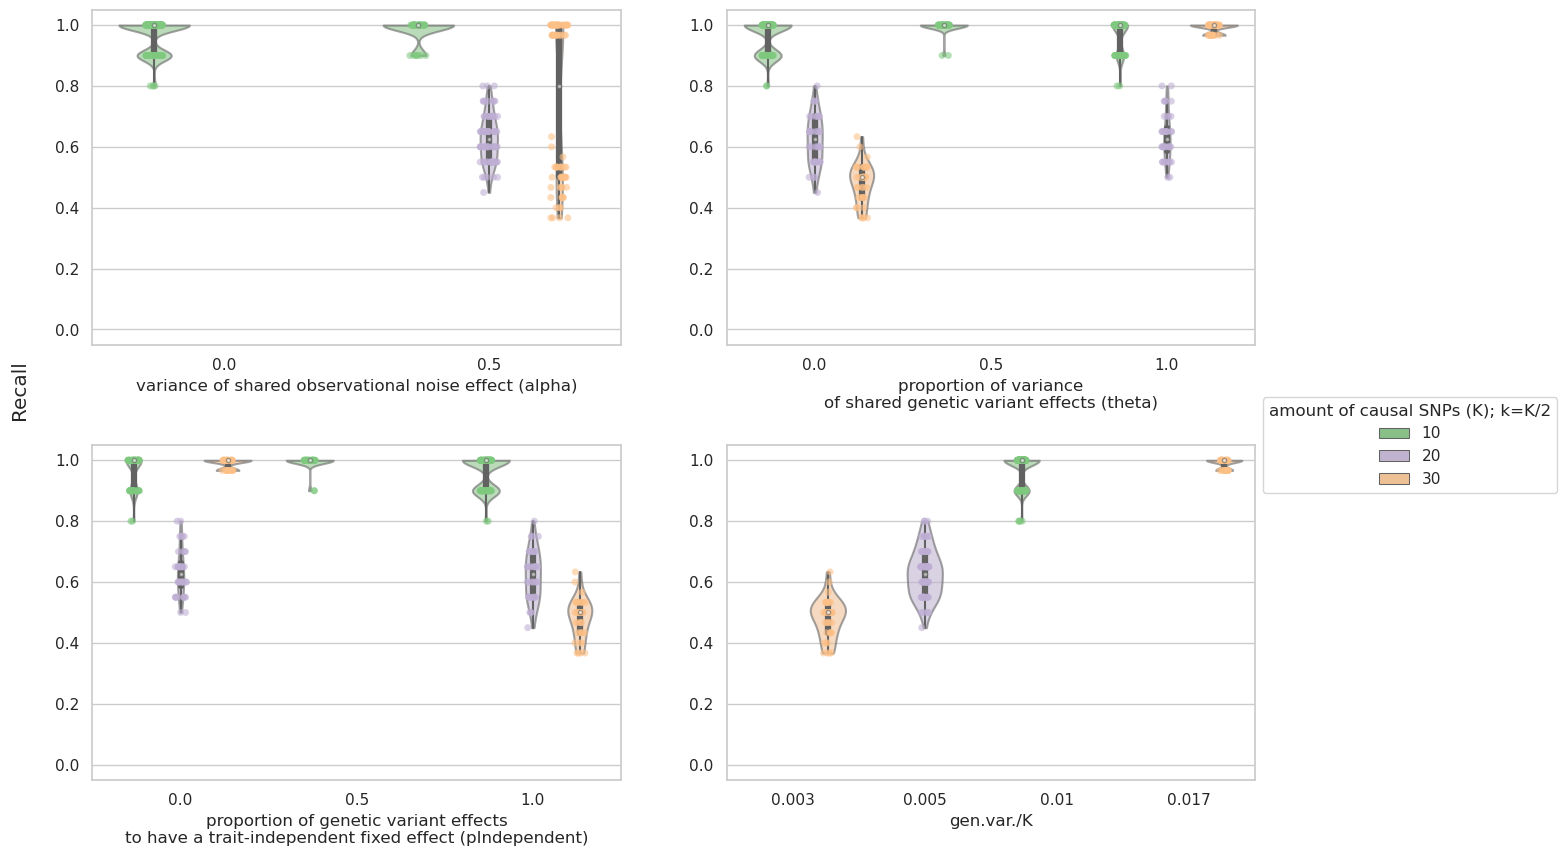

<Figure size 1500x1000 with 0 Axes>

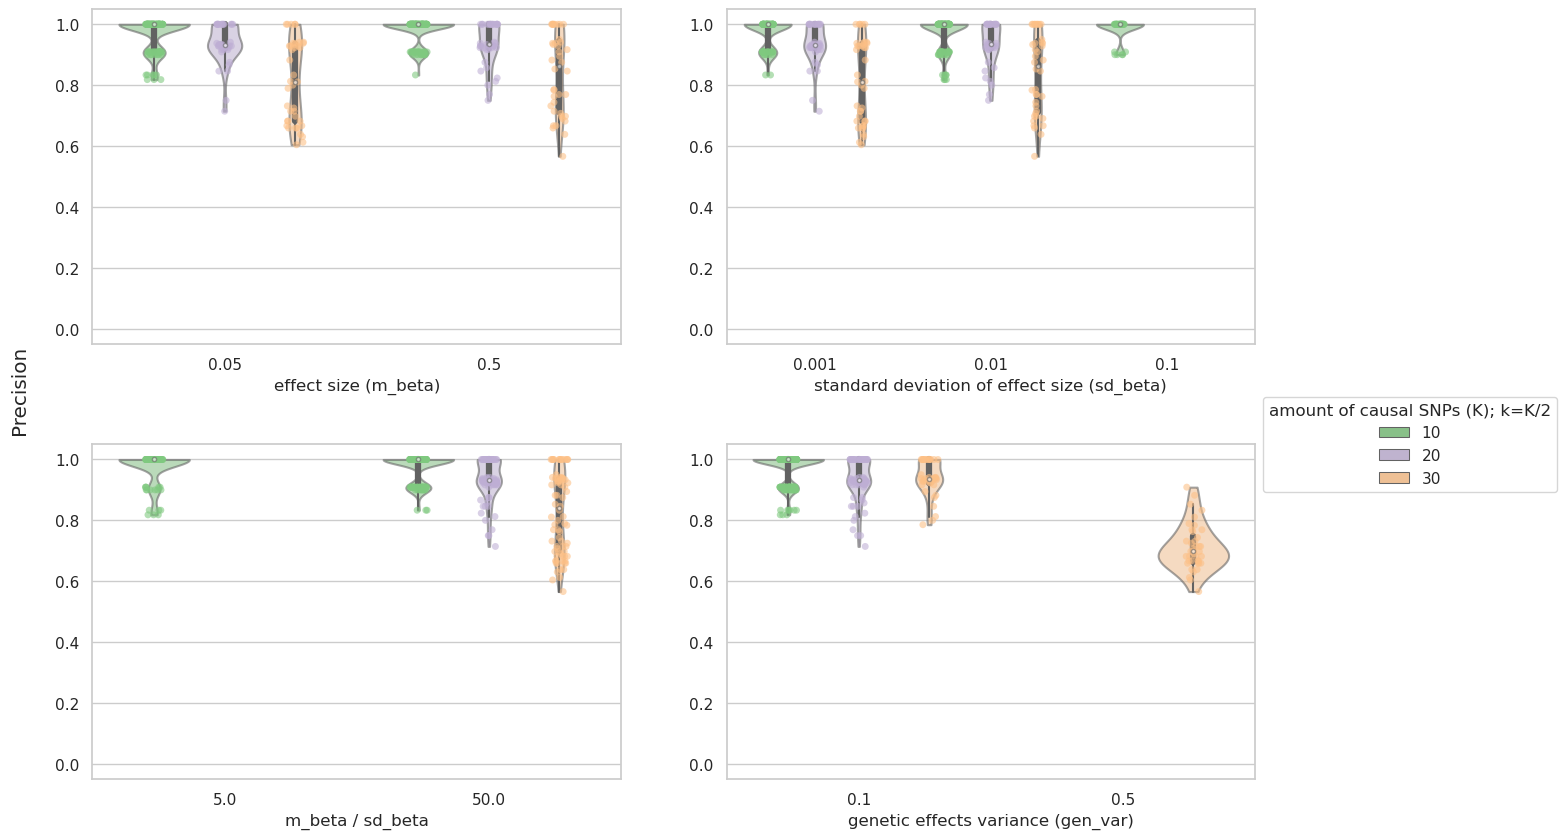

<Figure size 1500x1000 with 0 Axes>

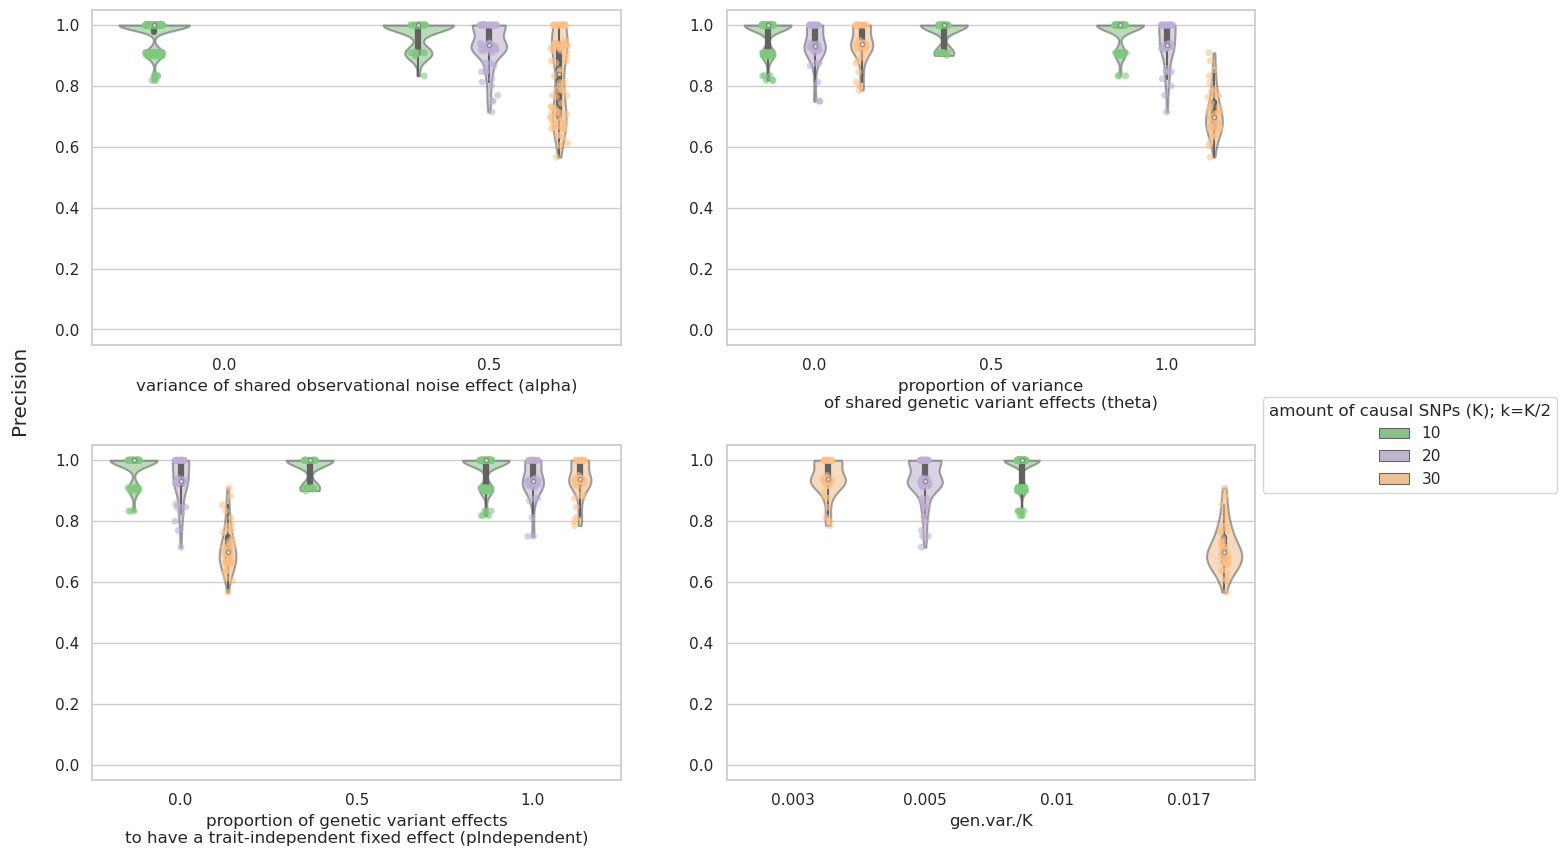

<Figure size 1500x1000 with 0 Axes>

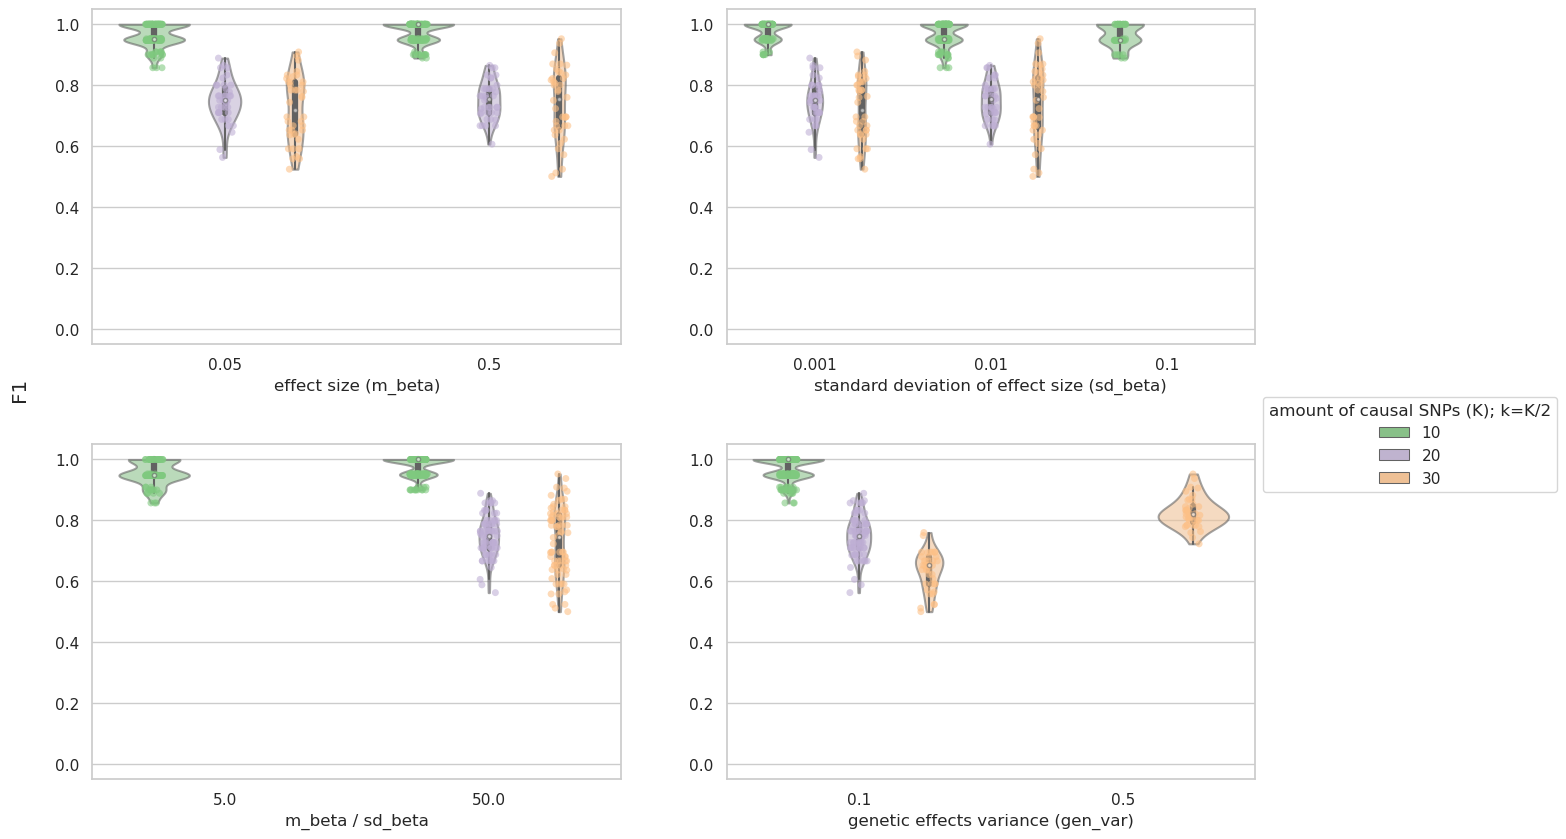

<Figure size 1500x1000 with 0 Axes>

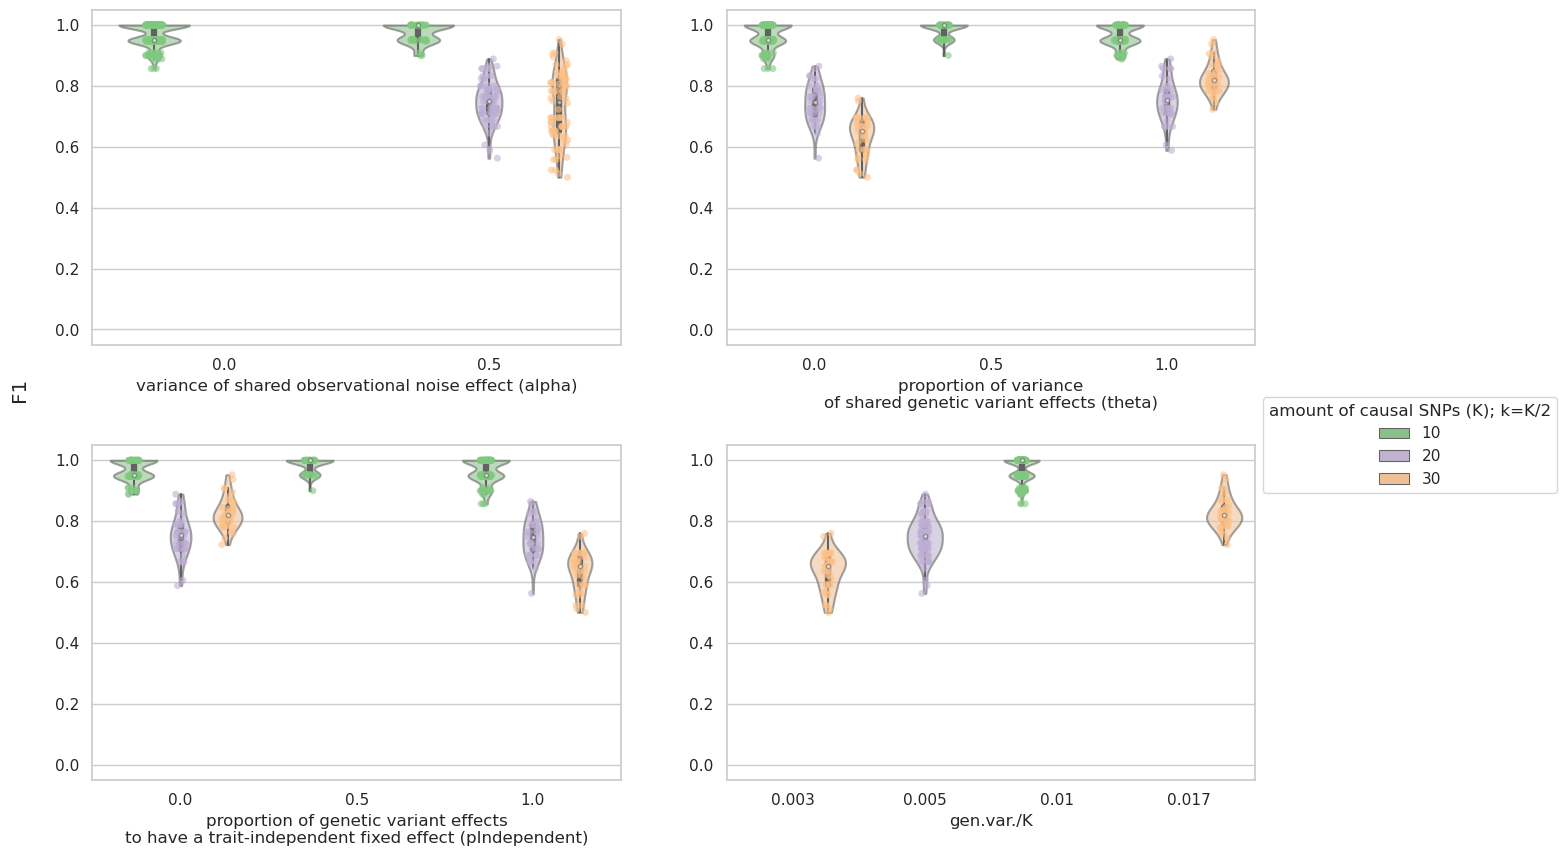

In [10]:
cur_ys = ['Recall', 'Precision', 'F1']
cur_names = [sf_name, cc_name, 'F1']

i=1
for cur_y, cur_name in zip(cur_ys, cur_names):
    for columns in columnses:
        name=f'images/extra_SF3.{i}.pdf'
        i+=1
        draw_violins(d, cur_y, cur_name, columns, name=name)

In [11]:
Xs_cols =["m_beta", "sd_beta", "m/sd", "gen_var", "alpha","theta","pIndep","gv/K",]

In [12]:
data_best = data.copy(deep=True).groupby(Xs_cols).agg({'F1':'mean'})

data_best = data_best[data_best.F1>0.95]
data_best

F1
m_beta sd_beta m/sd gen_var alpha theta pIndep gv/K          
0.05   0.001   50.0 0.1     0.0   0.0   1.0    0.01  0.973312
                                  0.5   0.5    0.01  0.978333
                                  1.0   0.0    0.01  0.967259
                            0.5   0.0   1.0    0.01  0.980213
       0.010   5.0  0.1     0.0   1.0   0.0    0.01  0.951602
0.50   0.010   50.0 0.1     0.0   0.0   1.0    0.01  0.974712
                                  0.5   0.5    0.01  0.987845
                                  1.0   0.0    0.01  0.975213
                            0.5   0.0   1.0    0.01  0.970655
       0.100   5.0  0.1     0.0   0.0   1.0    0.01  0.950192
                                  1.0   0.0    0.01  0.977093

In [13]:
# best_groups = list(data_best.index)
# item_names = list(data_best.index.names)

In [14]:
# grouped = data.groupby(Xs_cols)
# array_of_data = {traits: group for traits, group in grouped}

In [15]:
# array_of_data

In [16]:
# sns.set(rc={"figure.figsize": (5, 5)})
# sns.set_theme(style="whitegrid")

# opposite_k = {10:[20,30,30:10}

# already_used = set()
# i=1
# for _traits in array_of_data:
#     # iterate pfver sets of parameters that can be good
#     traits = list(deepcopy(_traits))
#     for K in [10, 30]:
#         traits[0]=K
#         try:
#             cur_data = array_of_data[tuple(traits)]
#             traits2 = deepcopy(traits)
#             traits2[0]=opposite_k[K]
#             if tuple(traits) not in best_groups and tuple(traits2) not in best_groups:
#                 continue
#         except KeyError:
#             continue
#         print('--------------------')
#         datas = []
#         cols = [cc_name, sf_name, 'F1']
#         for col in cols:
#             cur_data['trait'] = col
#             d1 = cur_data[[col, 'trait']].rename(columns={col:'score'})
#             datas.append(d1)
#         cur_data_m = pd.concat(datas)
#         grouped = cur_data_m.groupby('trait')['score'].agg(['mean', 'std'])
#         print({k: t for k, t in zip(Xs_cols, traits)})
#         display(grouped)
        
#         ax = sns.stripplot(data=cur_data_m, 
#                        x='trait', 
#                        y='score',
#                        palette=PALETTE,
#                            dodge=False
#                            )
        
#         ax = sns.violinplot(data=cur_data_m, 
#                        x='trait', 
#                        y='score',
#                        palette=PALETTE,
#                             cut=0
#                            )
#         plt.setp(ax.collections, alpha=.58)
#         ax.set(ylim=(0.6, 1.05))
# #         ax.legend_.remove()
#         full_x_axis_name = ', '.join([f"{name}={value}" for name, value in zip(item_names, traits)])
#         ax.set(ylabel='Score', xlabel=line_break(full_x_axis_name, k=3))
#         plt.savefig(f'images/F2.{i}.pdf')
#         plt.show()
#         i+=1
#         print('--------------------')
#     print('================================================================')